Цели: 
1) EDA для анализа влияния условий жизни учащихся на результаты госэкзамена по математике

2) Определить связи различных переменных с результатами госэкзамена и определиться с параметрами будущей модели


In [31]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
%matplotlib inline
labelencoder = LabelEncoder()

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
math = pd.read_csv('stud_math.xls')

In [32]:
def na_checks(dataset):
    """Функция для визуализации пропусков в датасете"""
    total = math.isnull().sum().sort_values(ascending=False)
    percent = round((math.isnull().sum()/math.isnull().count()
                     ).sort_values(ascending=False)*100, 2)
    missing_data = pd.concat([total, percent], axis=1, keys=[
                             'Total missing values', 'Percent'])
    f, ax = plt.subplots(figsize=(15, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=missing_data.index, y=missing_data['Percent'])
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent missing', fontsize=15)
    plt.title('Percent missing by feature', fontsize=15)
    return missing_data


def printmd(string):
    """Функция для форматирования текста в bold"""
    display(Markdown(string))


def analyze(column):
    """Функция для первичного анализа данных в столбцах"""
    if math[column].dtype == np.object:
        # заполняем пропуски значением No value для построения гистограммы
        df = math[column].fillna('No value')
    if math[column].dtype == np.float64 or math[column].dtype == np.int64:
        df = math[column]
    sns.histplot(df, color='orange', legend=False)
    printmd('**Столбец {}**'.format(column))
    plt.show()
    print(pd.DataFrame(df.value_counts()),'\n')
    print('К-во уникальных значений в столбце:', len(math[column].value_counts().index)),
    print('К-во NA значений:', math[column].isna().sum(), '\n'), 
    math.loc[:, [column]].info()
    print('\n',math[column].describe())


def boxplot(column):
    "Функция для построения боксплотов для визуализации респределения баллов в зависимости от значения номинативных переменных"
    sns.set_style("whitegrid")
    box_plot = sns.boxplot(x=math[column], y=math['score'], data=math)
    medians = math.groupby([column])['score'].median()
    vertical_offset = math['score'].median() * 0.05  # отступ от линии медианы
    for xtick in box_plot.get_xticks():
        box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
                      horizontalalignment='center', size='small', color='y', weight='bold')  # вывод значения медианы на график
    box_plot.set_title('Boxplot for ' + column)
    plt.show()


def fill_nans(column):
    "Функция, заполняющая значения NaN модой или медианой в зависимости от типа данных"
    if math[column].dtype == np.object:
        return math[column].fillna(math[column].mode()[0], inplace=True)
    if math[column].dtype == np.float64 or math[column].dtype == np.int64:
        return math[column].fillna(math[column].median(), inplace=True)


def get_stat_dif(column):
    "Функция для определения статистически значимых различий с помощью теста Стьюдента"
    cols = math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(math.loc[math.loc[:, column] == comb[0], 'score'],
                     math.loc[math.loc[:, column] == comb[1], 'score'], nan_policy='omit').pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
        if ttest_ind(math.loc[math.loc[:, column] == comb[0], 'score'],
                     math.loc[math.loc[:, column] == comb[1], 'score'], nan_policy='omit').pvalue \
                > 0.05/len(combinations_all):
            print('Статистически значимые различия НЕ найдены для колонки', column)
            break

# Первичный осмотр данных

In [33]:
display(math.head())
math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Всего в датасете 395 строк и 30 колонок, 17 из которых являются строковыми, а остальные 13 - числовыми. В некоторых колонках присутствуют пропуски.

In [34]:
numeric_features = math.select_dtypes(include=[np.number])
display(numeric_features.columns)
print('К-во числовых столбцов в датасете:', len(numeric_features.columns))

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'studytime, granular', 'famrel', 'freetime', 'goout', 'health',
       'absences', 'score'],
      dtype='object')

К-во числовых столбцов в датасете: 13


In [35]:
categorical_features = math.select_dtypes(include=[np.object])
display(categorical_features.columns)
print('К-во строковых столбцов в датасете:', len(categorical_features.columns))

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')

К-во строковых столбцов в датасете: 17


### Поверхностный анализ числовых признаков

In [36]:
math.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


Бросается в глаза максимальное значение Fedu (образование отца): из описания датасета следует, что максимальное значение (4) соответствует высшему. Значение 40 может быть ошибкой, исходя из того, что медианное значение 2. 
Столбец absences с самым большим разбросом значений и, скорей всего, имеющимися выбросами. 
Имеются пропуски в целевой переменной score (6), которые нужно будет удалить, поскольку на их основе невозможно обучить модель. Также имеются 0-вые значения, которые могут обозначать как значение оценки, так и ее отсутствие. 
Все столбцы будут более детально рассмотрены ниже.

### Визуализация пропусков

,Total missing values,Percent
Pstatus,45,11.39
paid,40,10.13
famsup,39,9.87
Fjob,36,9.11
internet,34,8.61
romantic,31,7.85
guardian,31,7.85
traveltime,28,7.09
famsize,27,6.84
famrel,27,6.84


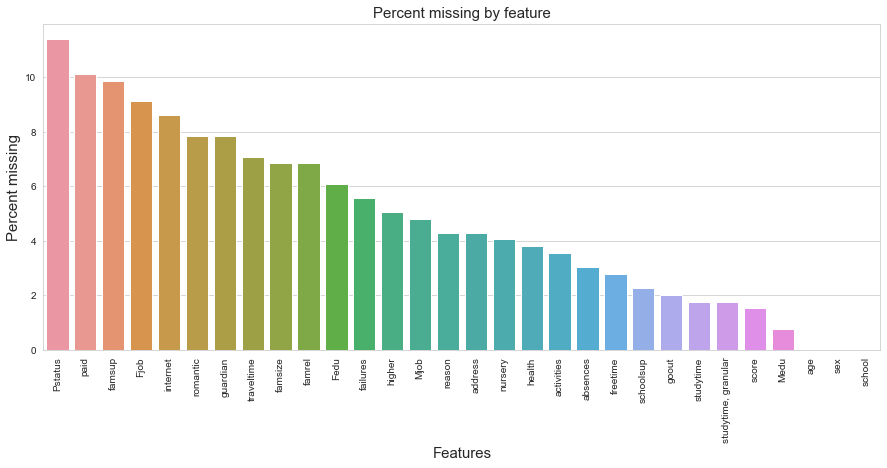

In [37]:
na_checks(math)

Наибольшее к-во пропусков (>10%) в переменной Pstatus (статус совместного жилья родителей). 3 столбца полностью без пропусков - age, sex, school. Во всех остальных столбцах процент пропусков ниже 10%, что является не большим и позволяет их восстановление простым способом, так как использование сложных методов не оправдано при данном значении. 

# Первичный анализ данных в столбцах

In [38]:
# сразу удаляем строки с пропусками в целевой переменной, так как эти данные невозможно использовать дальше
math = math.dropna(subset=['score'], axis=0)

**Столбец age**

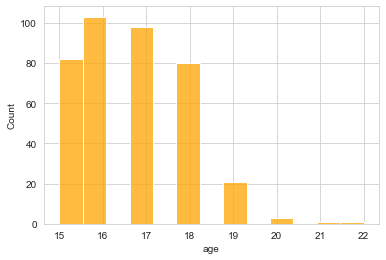

    age
16  103
17   98
15   82
18   80
19   21
20    3
22    1
21    1 

К-во уникальных значений в столбце: 8
К-во NA значений: 0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     389 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB

 count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64




**Столбец Medu**

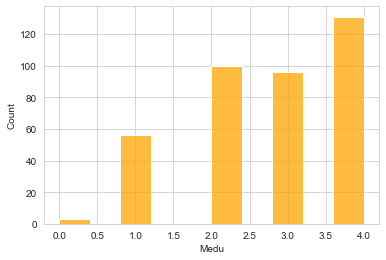

     Medu
4.0   131
2.0   100
3.0    96
1.0    56
0.0     3 

К-во уникальных значений в столбце: 5
К-во NA значений: 3 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Medu    386 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB

 count    386.000000
mean       2.766839
std        1.094277
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64




**Столбец Fedu**

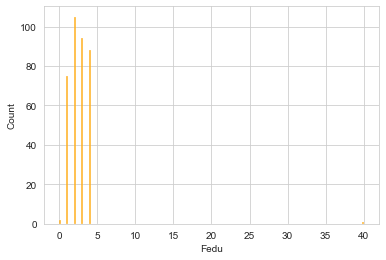

      Fedu
2.0    105
3.0     94
4.0     88
1.0     75
0.0      2
40.0     1 

К-во уникальных значений в столбце: 6
К-во NA значений: 24 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fedu    365 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB

 count    365.000000
mean       2.627397
std        2.241790
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64




In [39]:
for x in numeric_features.columns[:3]:
    analyze(x)
    print('\n')

Столбец Age - без пропусков и без выбросов, исходя из описания переменной (ученики возрастом от 15 до 22)

Столбец Medu - исходя из описания переменной, значения 0 не являются пропуском, а несут смысловую нагрузку (отсутствие образования у матери). Выбросов не обнаружено. 3 значения NaN.

Столбец Fedu - есть пропуски и выбросы. Исходя из описания переменной и пользуюсь здравым смыслом, значение 40 - ошибка, поэтому ее можно отфильтровать



In [40]:
# фильтруем данные, исключая ошибку в столбце
math.drop(math[math['Fedu'] == 40].index, inplace=True)

**Столбец traveltime**

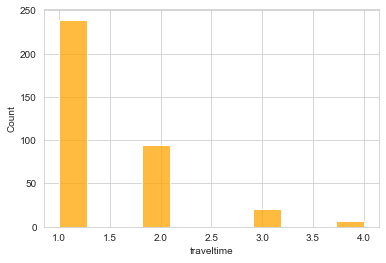

     traveltime
1.0         239
2.0          94
3.0          20
4.0           7 

К-во уникальных значений в столбце: 4
К-во NA значений: 28 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  360 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB

 count    360.000000
mean       1.430556
std        0.688675
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64




**Столбец studytime**

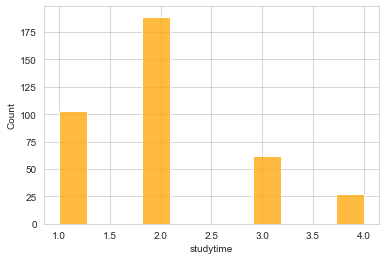

     studytime
2.0        189
1.0        103
3.0         62
4.0         27 

К-во уникальных значений в столбце: 4
К-во NA значений: 7 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  381 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB

 count    381.000000
mean       2.034121
std        0.846908
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64




**Столбец failures**

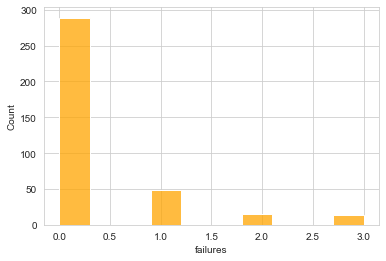

     failures
0.0       289
1.0        48
2.0        15
3.0        14 

К-во уникальных значений в столбце: 4
К-во NA значений: 22 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  366 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB

 count    366.000000
mean       0.327869
std        0.730276
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64




**Столбец studytime, granular**

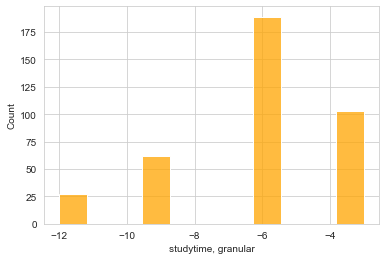

       studytime, granular
-6.0                   189
-3.0                   103
-9.0                    62
-12.0                   27 

К-во уникальных значений в столбце: 4
К-во NA значений: 7 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 394
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studytime, granular  381 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB

 count    381.000000
mean      -6.102362
std        2.540725
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64




**Столбец famrel**

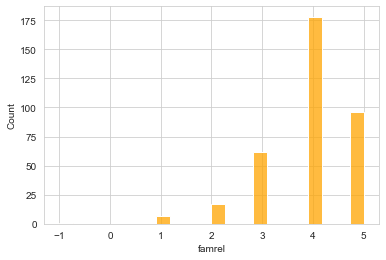

      famrel
 4.0     178
 5.0      96
 3.0      62
 2.0      17
 1.0       7
-1.0       1 

К-во уникальных значений в столбце: 6
К-во NA значений: 27 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  361 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB

 count    361.000000
mean       3.927978
std        0.931139
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64




In [41]:
for x in numeric_features.columns[3:8]:
    analyze(x)
    print('\n')

Все выше рассмотренные параметры являются категориальными. Уникальные значения каждой из переменной несут определенную смысловую нагрузку, исходя из описания датасета. Следовательно, выбросов не наблюдается, кроме столбца famrel (значение -1). В каждом из параметров есть пустые значения. Заполнение этих значений будет проведено после корреляционного анализа для тех параметров, которые будут использованы для построения будущей модели.

In [42]:
# фильтруем данные, исключая ошибку в столбце famrel
math.drop(math[math['famrel'] == -1].index, inplace=True)

**Столбец freetime**

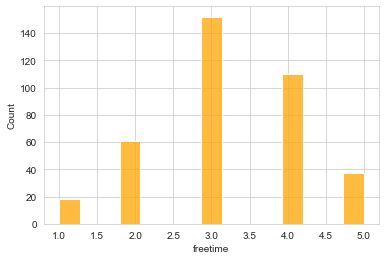

     freetime
3.0       152
4.0       110
2.0        61
5.0        37
1.0        18 

К-во уникальных значений в столбце: 5
К-во NA значений: 9 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  378 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB

 count    378.000000
mean       3.230159
std        0.991979
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64




**Столбец goout**

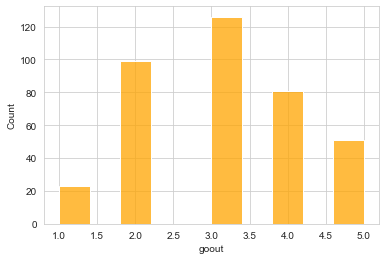

     goout
3.0    126
2.0     99
4.0     81
5.0     51
1.0     23 

К-во уникальных значений в столбце: 5
К-во NA значений: 7 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   380 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB

 count    380.000000
mean       3.100000
std        1.116204
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64




**Столбец health**

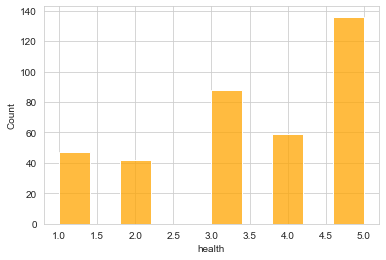

     health
5.0     136
3.0      88
4.0      59
1.0      47
2.0      42 

К-во уникальных значений в столбце: 5
К-во NA значений: 15 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  372 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB

 count    372.000000
mean       3.524194
std        1.403483
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64




**Столбец absences**

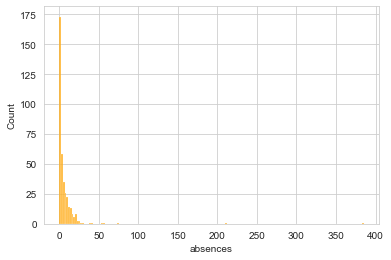

       absences
0.0         110
2.0          60
4.0          51
6.0          30
8.0          20
10.0         17
12.0         12
14.0         11
3.0           7
16.0          7
7.0           6
18.0          5
5.0           5
20.0          4
22.0          3
9.0           3
1.0           3
15.0          2
13.0          2
11.0          2
25.0          1
54.0          1
385.0         1
26.0          1
56.0          1
24.0          1
212.0         1
21.0          1
75.0          1
30.0          1
19.0          1
38.0          1
40.0          1
23.0          1
17.0          1
28.0          1 

К-во уникальных значений в столбце: 36
К-во NA значений: 11 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  376 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB

 count    376.000000
mean       7.311170
std       23.675281
min        0.000000
2

In [43]:
for x in numeric_features.columns[8:-1]:
    analyze(x)
    print('\n')

Столбец absences: имеются экстримные значения, которые выбиваются из датасета. Большинство значений (75%) лежат от 0 до 8. Воспользуемся формулой межквартильного расстнояния для определения выбросов

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


<AxesSubplot:>

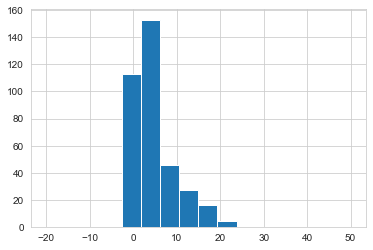

In [44]:
perc25 = math.absences.quantile(0.25)
perc75 = math.absences.quantile(0.75)
IQR = perc75 - perc25

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

math.absences.loc[math.absences.between(
    perc25 - 1.5*IQR,
    perc75 + 1.5*IQR)].hist(bins=16, range=(-20, 50), label='IQR')

С другой стороны, пользуясь логикой и исходя из описания переменной, значения выше верхней границы выбросов выглядят достаточно реальными. На боксплоте заметны два значения, которые сильно оторваны от остальных. Отфильтруем пока только их

<AxesSubplot:>

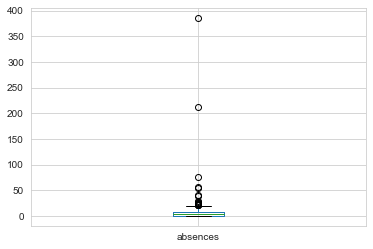

In [45]:
math.boxplot(column=['absences'])

In [46]:
math.drop(math[math['absences'] > 100].index, inplace=True)

**Столбец score**

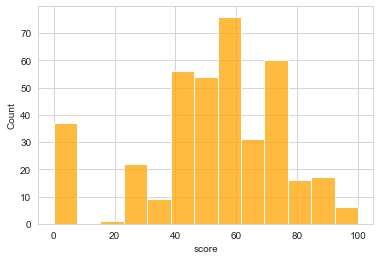

       score
50.0      54
55.0      46
0.0       37
75.0      33
65.0      31
40.0      30
60.0      30
70.0      27
45.0      26
80.0      16
30.0      15
90.0      12
35.0       9
25.0       7
95.0       5
85.0       5
100.0      1
20.0       1 

К-во уникальных значений в столбце: 18
К-во NA значений: 0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   385 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB

 count    385.000000
mean      52.207792
std       22.962457
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64


In [47]:
analyze(numeric_features.columns[-1])

Исходя из распределения данных, экзамен оценивается по 100-бальной системе. 37 нулевых значений, которые могут обозначать, что экзамен не засчитан/не пройден. При этом между 0 и 20 нету абсолютно никаких промежуточных значений, что может говорить о том, что 20 баллов - это минимальная возможная оценка, а 0, например, значение проваленного экзамена. Так как будущая модель должна предсказывать результат госэкзамена (не параметр сдал/не сдал) предлагается удалить все значения 0

In [48]:
math.drop(math[math['score'] == 0].index, inplace=True)

# Корреляционный анализ

Проанализируем пока что только числовые столбцы

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.161704,-0.138018,0.081508,-0.015556,0.228047,0.015556,0.068899,0.029023,0.135107,-0.065946,0.093592,-0.155726
Medu,-0.161704,1.000000,0.275598,-0.173515,0.078589,-0.245463,-0.078589,-0.010050,0.025335,0.064164,-0.045051,-0.011944,0.213349
Fedu,-0.138018,0.275598,1.000000,0.030646,0.057199,-0.150821,-0.057199,0.040577,-0.066556,-0.023282,0.027251,0.004695,0.078573
traveltime,0.081508,-0.173515,0.030646,1.000000,-0.102206,0.064699,0.102206,-0.016857,-0.021937,0.037636,-0.021531,-0.048215,-0.070559
studytime,-0.015556,0.078589,0.057199,-0.102206,1.000000,-0.178992,-1.000000,0.045894,-0.121969,-0.051280,-0.080016,-0.026544,0.115741
failures,0.228047,-0.245463,-0.150821,0.064699,-0.178992,1.000000,0.178992,-0.022655,0.098382,0.120914,0.081284,0.057391,-0.344338
"studytime, granular",0.015556,-0.078589,-0.057199,0.102206,-1.000000,0.178992,1.000000,-0.045894,0.121969,0.051280,0.080016,0.026544,-0.115741
famrel,0.068899,-0.010050,0.040577,-0.016857,0.045894,-0.022655,-0.045894,1.000000,0.175743,0.081154,0.077474,-0.082609,0.057112
freetime,0.029023,0.025335,-0.066556,-0.021937,-0.121969,0.098382,0.121969,0.175743,1.000000,0.296437,0.061575,0.009292,0.019026
goout,0.135107,0.064164,-0.023282,0.037636,-0.051280,0.120914,0.051280,0.081154,0.296437,1.000000,-0.015608,-0.048738,-0.129685


<AxesSubplot:>

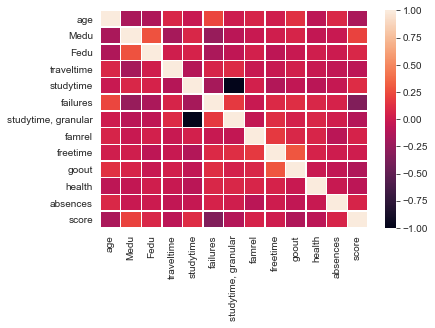

In [49]:
display(numeric_features.corr())
sns.heatmap(numeric_features.corr(), linewidths=.5)

1) наблюдаем 100% негативную корреляцию между параметрами studytime и studytime, granular. Это позволяет исключить одну из переменных, пусть это будет studytime, granular, так как значения studytime более понятны в интерпретации 

2) других существенно скоррелированных параметров для исключения одного из них не наблюдается

3) заметна негативная корреляция между failures и score (-0.35), что достаточно логично: чем меньше к-во внеучебных неудач, тем больше баллов по экзамену

4) позитивная корреляция между Medu и Fedu, что может свидетельствовать о том, что обычно при наличии высшего образования у одного из родителей, уровень образования второго тоже выше и наоборот

5) позитивная корреляция между freetime и gooout, что тоже логично: ученики со свободным временем после школы больше времени проводят с друзьями


In [50]:
# удаляем столбец, так как он полностью скоррелирован с studytime
math = math.drop(['studytime, granular'], axis=1)

# Анализ номинативных переменных

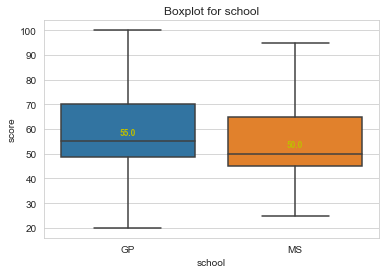

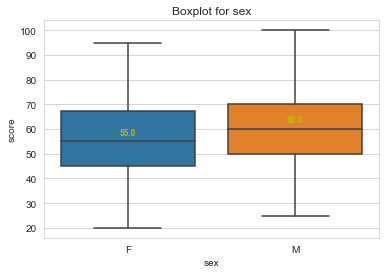

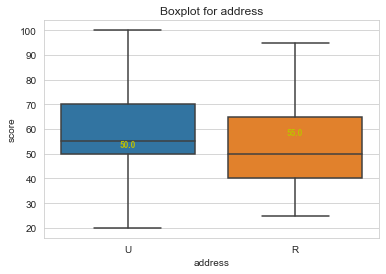

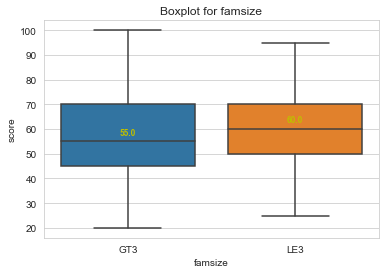

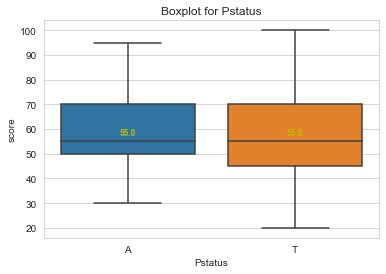

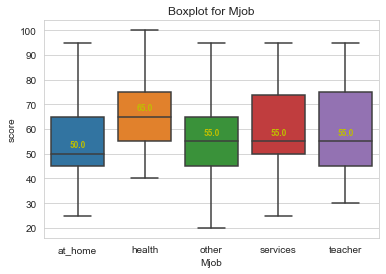

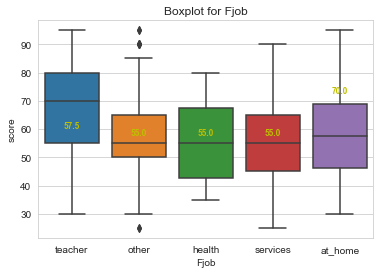

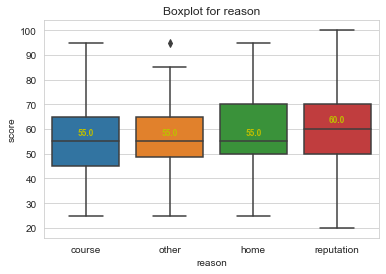

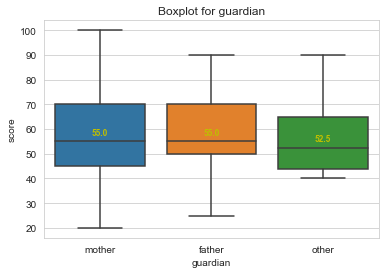

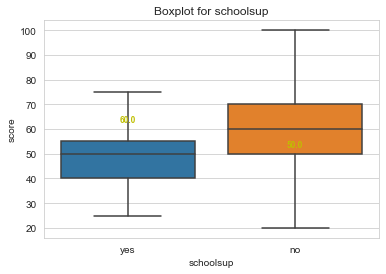

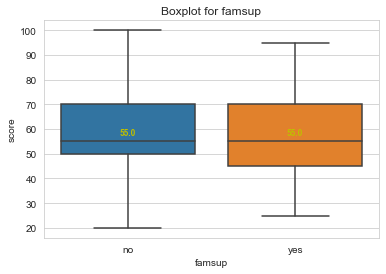

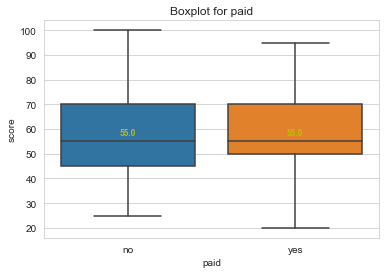

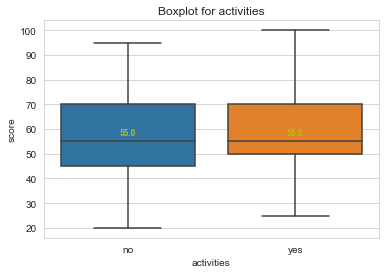

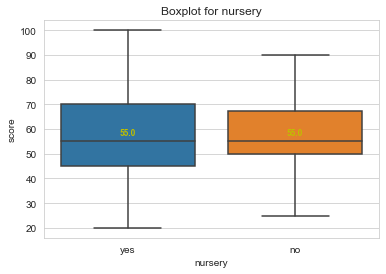

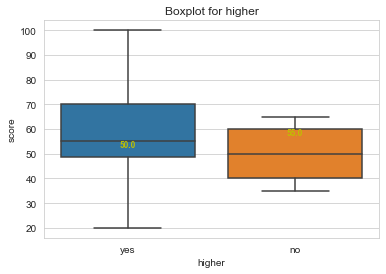

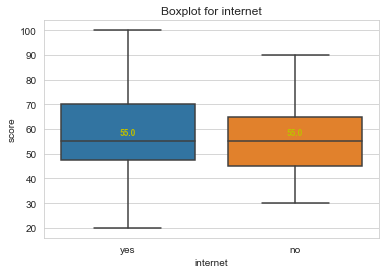

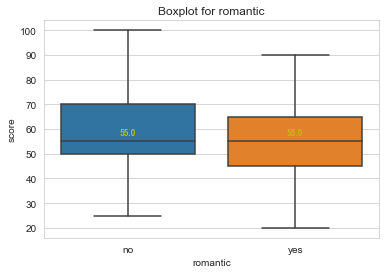

In [51]:
for col in categorical_features.columns:
    boxplot(col)

Исходя из графиков, все параметры, кроме Pstatus, famsup, paid, activities, nursery, internet, romantic, могут влиять на переменную score (баллы по госэкзамену по математике), так как ее медианное значение меняется в зависимости от значения номинального параметра.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента.


In [52]:
for col in categorical_features.columns:
    get_stat_dif(col)

Статистически значимые различия НЕ найдены для колонки school
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Статистически значимые различия НЕ найдены для колонки famsize
Статистически значимые различия НЕ найдены для колонки Pstatus
Статистически значимые различия НЕ найдены для колонки Mjob
Статистически значимые различия НЕ найдены для колонки Fjob
Статистически значимые различия НЕ найдены для колонки reason
Статистически значимые различия НЕ найдены для колонки guardian
Найдены статистически значимые различия для колонки schoolsup
Статистически значимые различия НЕ найдены для колонки famsup
Статистически значимые различия НЕ найдены для колонки paid
Статистически значимые различия НЕ найдены для колонки activities
Статистически значимые различия НЕ найдены для колонки nursery
Статистически значимые различия НЕ найдены для колонки higher
Статистически значимые различия НЕ найдены для колонки internet
Статистичес

Как мы видим, серьёзно отличаются три параметра: sex,  address и  schoolsup. Оставим эти переменные в датасете для дальнейшего построения модели. Попробуем закодировать их в 1 и 0 и посмотрим, есть ли корреляция с числовыми признаками.

Для этого сначала заполним пустые значения модой для правильной отработки encoderа. Поскольку пропусков в выбранных колонках меньше 5% - заполнение не должно сильно исказить данные и корреляцию

In [53]:
# удаляем параметры без значимых различий
math = math.drop(['school', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
                  'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'], axis=1)

In [54]:
# для начала заполним пустые значения модой, чтобы корректно сработал encoder
math['address'].fillna(math['address'].mode()[0], inplace=True)
math['schoolsup'].fillna(math['schoolsup'].mode()[0], inplace=True)

In [55]:
# обновляем переменную, так как были удалены столбцы
categorical_features = math.select_dtypes(include=[np.object])
for column in categorical_features.columns:
    math[column] = labelencoder.fit_transform(math[column])

Обновленные значения: sex (1 - M, 0 - F), address (U - 1, R - 0), schoolsup (yes - 1 , no - 0)

In [56]:
math.corr()

,sex,age,address,Medu,Fedu,traveltime,studytime,failures,schoolsup,famrel,freetime,goout,health,absences,score
sex,1.000000,-0.040838,0.020492,0.058781,0.020397,0.053702,-0.298471,0.026351,-0.148449,0.040581,0.202809,0.058602,0.146908,-0.086389,0.108072
age,-0.040838,1.000000,-0.152284,-0.124274,-0.122972,0.110123,-0.008774,0.224784,-0.254790,0.062164,-0.016150,0.111766,-0.057461,0.212169,-0.126714
address,0.020492,-0.152284,1.000000,0.163577,0.084858,-0.274214,-0.048025,-0.108623,0.017742,0.018357,0.065920,0.065657,-0.022133,-0.047641,0.140344
Medu,0.058781,-0.124274,0.163577,1.000000,0.612187,-0.166662,0.070539,-0.201098,-0.052656,-0.013881,0.019180,0.074769,-0.035073,0.075615,0.188154
Fedu,0.020397,-0.122972,0.084858,0.612187,1.000000,-0.158477,-0.017590,-0.265252,0.045667,-0.023084,-0.024636,0.051175,0.020127,0.032747,0.131049
traveltime,0.053702,0.110123,-0.274214,-0.166662,-0.158477,1.000000,-0.113714,0.107924,-0.003190,-0.048816,-0.013993,0.032976,-0.000622,-0.003992,-0.078184
studytime,-0.298471,-0.008774,-0.048025,0.070539,-0.017590,-0.113714,1.000000,-0.148401,0.019455,0.041468,-0.130566,-0.030581,-0.083284,-0.074363,0.139299
failures,0.026351,0.224784,-0.108623,-0.201098,-0.265252,0.107924,-0.148401,1.000000,0.070184,0.024268,0.125360,0.128448,0.053752,0.130092,-0.280505
schoolsup,-0.148449,-0.254790,0.017742,-0.052656,0.045667,-0.003190,0.019455,0.070184,1.000000,0.019602,-0.051262,-0.019233,-0.024225,0.008421,-0.257320
famrel,0.040581,0.062164,0.018357,-0.013881,-0.023084,-0.048816,0.041468,0.024268,0.019602,1.000000,0.148139,0.023419,0.116915,-0.052387,0.044664


Полностью или почти полностью скоррелированных дополнительных переменных после замены значений не наблюдается

#  Замена пропусков

Поскольку процент пропусков в оставшихся столбцах не превышает 10%, используем самый простой метод - замена модой для номинативных параметров и замена медианой для числовых

In [57]:
for column in math.columns:
    fill_nans(column)

In [58]:
# проверим, если пропуски были заполнены верно
math.isnull().sum()

sex           0
age           0
address       0
Medu          0
Fedu          0
traveltime    0
studytime     0
failures      0
schoolsup     0
famrel        0
freetime      0
goout         0
health        0
absences      0
score         0
dtype: int64

In [59]:
math.head()

,sex,age,address,Medu,Fedu,traveltime,studytime,failures,schoolsup,famrel,freetime,goout,health,absences,score
0,0,18,1,4.0,4.0,2.0,2.0,0.0,1,4.0,3.0,4.0,3.0,6.0,30.0
1,0,17,1,1.0,1.0,1.0,2.0,0.0,0,5.0,3.0,3.0,3.0,4.0,30.0
2,0,15,1,1.0,1.0,1.0,2.0,3.0,1,4.0,3.0,2.0,3.0,10.0,50.0
3,0,15,1,4.0,2.0,1.0,3.0,0.0,0,3.0,2.0,2.0,5.0,2.0,75.0
4,0,16,1,3.0,3.0,1.0,2.0,0.0,0,4.0,3.0,2.0,5.0,4.0,50.0


# Выводы

В результате EDA для анализа влияния условий жизни учащихся на результаты госэкзамена по математике были получены следующие выводы:

1) В данных немного пустых значений (до 10% для каждого параметра), за исключением Pstatus, что не существенно, поскольку данный параметр был удален в силу отсутствия статестически значемых различий в рамках теста Стьюдента.


2) Выбросы в столбцах Fedu (образование отца) и Famrel (семейные отношения) - в виде ошибок, а так же в столбце Absences (к-во пропусков). Также были обнаружены нетипичные значения в целевой переменной Score, которые были удалены. В общем, данные выглядят достаточно чистыми исходя из к-ва параметров. 


3) Была обнаружена негативная корреляция между параметрами absence и score, а также между failures и score, что может говорить о том, что ученики с меньшим к-во пропусков (или их отсутствием), а также меньшим к-вом внеучебных неудач (или их отсутствием)  имеют более высокие баллы по госэкзамену. 


4) Были отобраны самые важные параметры, которые предлагается использовать в дальнейшем для построения модели: 'sex', 'age', 'address', 'Medu', 'Fedu', 'traveltime', 'studytime','failures', 'schoolsup', 'famrel', 'freetime', 'goout', 'health', 'absences'.

